# Regressão Logística Binária

Para está atividade iremos utilizar um dataset sobre fraudes em cartão de crédito obtido do [kaggle](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud?select=card_transdata.csv).

Esse conjunto de dados possui as variáveis:

* distance_from_home - distância entre a casa e o local onde a transação foi feita.

* distance_from_last_transaction - a distância do local em que a última transação ocorreu.

* ratio_to_median_purchase_price - Razão entre preço da transação e o preço médio de transação.

* repeat_retailer - Se a transação ocorreu na mesma loja.

* used_chip - Se a transação foi feita com cartão de crédito.

* used_pin_number - Se a transação ocorreu usando número PIN.

* online_order - Se a transação foi online.

* fraud - Se a transação é fraudulenta.


In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# importando o statsmodels para criar o modelo de regressão logística
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, roc_auc_score


## Atividade 1: Carregue os dados e verifique se há dados faltantes. Se houver, faça o tratamento que julgar adequado.

In [79]:
# seu código
df = pd.read_csv('card_transdata.csv')

In [80]:
# seu código
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


Obs: Na célula abaixo há um código para renomear as colunas.

In [81]:
# renomeando as colunas
df.columns = ['dist_casa','dist_ultima_transacao','razao_preco_medio',
              'loja_repetida','usou_chip','usou_pin','online','fraude']

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   dist_casa              1000000 non-null  float64
 1   dist_ultima_transacao  1000000 non-null  float64
 2   razao_preco_medio      1000000 non-null  float64
 3   loja_repetida          1000000 non-null  float64
 4   usou_chip              1000000 non-null  float64
 5   usou_pin               1000000 non-null  float64
 6   online                 1000000 non-null  float64
 7   fraude                 1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [83]:
df.head(2)

,dist_casa,dist_ultima_transacao,razao_preco_medio,loja_repetida,usou_chip,usou_pin,online,fraude
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


In [84]:
df = df.astype({'loja_repetida':int,'usou_chip':int,'usou_pin':int,'online':int,'fraude':int})

## Atividade 2: Selecione as variáveis que achar interessante para tentar prever se houve ou não fraude.

In [85]:
# seu código
df.head()

,dist_casa,dist_ultima_transacao,razao_preco_medio,loja_repetida,usou_chip,usou_pin,online,fraude
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


In [86]:
# seu código
correl = df.corr()
correl.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\leolk\AppData\Local\Temp\ipykernel_13488\675314900.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correl.style.background_gradient(cmap='coolwarm').set_precision(2)


,dist_casa,dist_ultima_transacao,razao_preco_medio,loja_repetida,usou_chip,usou_pin,online,fraude
dist_casa,1.00,0.00,-0.00,0.14,-0.00,-0.00,-0.00,0.19
dist_ultima_transacao,0.00,1.00,0.00,-0.00,0.00,-0.00,0.00,0.09
razao_preco_medio,-0.00,0.00,1.00,0.00,0.00,0.00,-0.00,0.46
loja_repetida,0.14,-0.00,0.00,1.00,-0.00,-0.00,-0.00,-0.00
usou_chip,-0.00,0.00,0.00,-0.00,1.00,-0.00,-0.00,-0.06
usou_pin,-0.00,-0.00,0.00,-0.00,-0.00,1.00,-0.00,-0.10
online,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.19
fraude,0.19,0.09,0.46,-0.00,-0.06,-0.10,0.19,1.00


In [87]:
# Dado o cenário acima, iremos utilizar apenas as variáveis acima de +-10% de corr
colunas = list(correl.loc[(abs(correl.fraude)>=0.1)&(correl.fraude!=1)].index)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   dist_casa              1000000 non-null  float64
 1   dist_ultima_transacao  1000000 non-null  float64
 2   razao_preco_medio      1000000 non-null  float64
 3   loja_repetida          1000000 non-null  int32  
 4   usou_chip              1000000 non-null  int32  
 5   usou_pin               1000000 non-null  int32  
 6   online                 1000000 non-null  int32  
 7   fraude                 1000000 non-null  int32  
dtypes: float64(3), int32(5)
memory usage: 42.0 MB


## Atividade 3: Verifique se há desbalanceamento da variável `fraude`. Se houver, faça um balanceamento de classes.

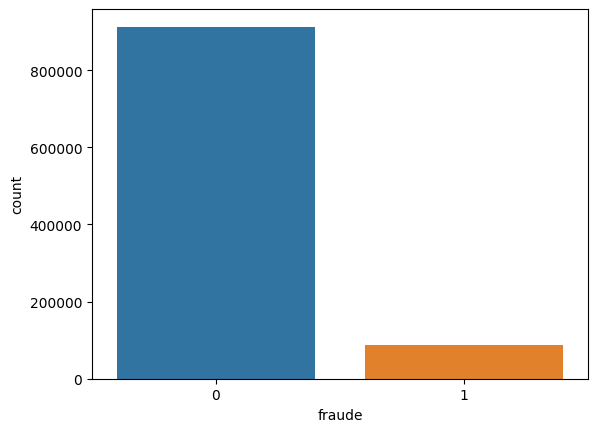

In [89]:
sns.countplot(x = df.fraude);

Se as classes estiverem desbalanceadas execute o código a seguir.

Existem várias técnicas de balanceamento. Como temos muitas observações, vamos usar uma técnica chamada undersampling. Esta técnica consiste em descartar observações da classe que possui mais observações até que as duas classes tenham a mesma quantidade.

Por exemplo, se temos duas classes, uma com 1000 observações para a classe A e outra com 100 observações para a classe B, então iremos selecionar apenas 100 observações (aleatoriamente) da classe A dentre as 1000. Dessa maneira iremos ter 100 observações de cada classe.

In [90]:
# separando as variáveis X e y
X = df[colunas]
y = df['fraude']

# balanceando as classes com undersampling
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

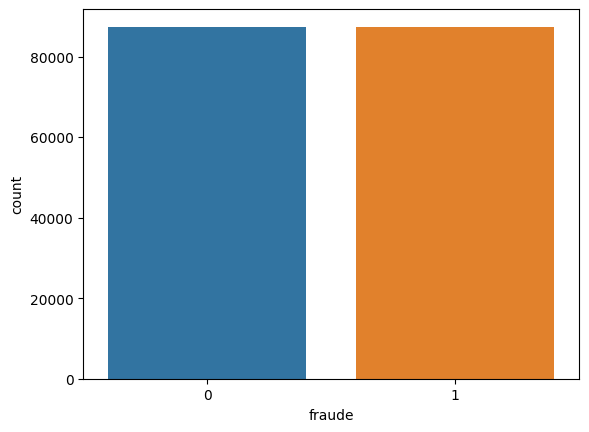

In [91]:
# seu código
sns.countplot(x = y);

## Atividade 4: Crie um modelo de regressão logística.

In [92]:
# Assim como na regressão linear, temos que adicionar uma constante à variável X.
X = sm.add_constant(X)

In [93]:
# criando modelo de regressão logística
modelo = sm.Logit(y, X).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.270563
         Iterations 9


## Atividade 5: Verifique os parâmetros do modelo e se eles são relevantes.

In [94]:
modelo.params

const               -6.615003
dist_casa            0.022040
razao_preco_medio    0.940263
usou_pin            -7.295589
online               3.730294
dtype: float64

## Atividade 6: Crie a matriz de confusão e o mapa de calor correspondente.


In [95]:
y_pred = (modelo.predict(X) >= 0.5).astype(int)

In [96]:
matriz_confusao = confusion_matrix(y, y_pred)
matriz_confusao

array([[80255,  7148],
       [ 8045, 79358]], dtype=int64)

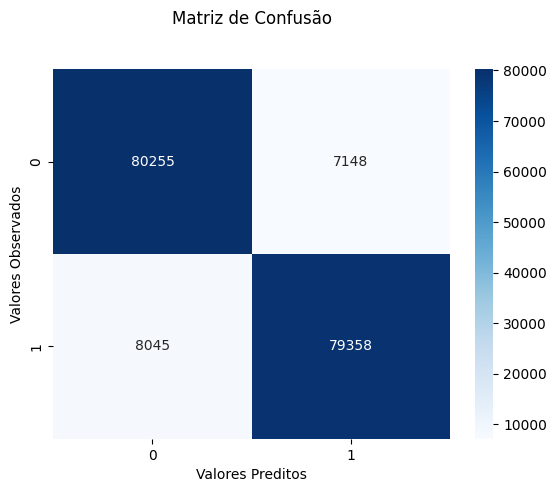

In [97]:
# seu código
# criando mapa de calor
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Valores Observados')
plt.xlabel('Valores Preditos');

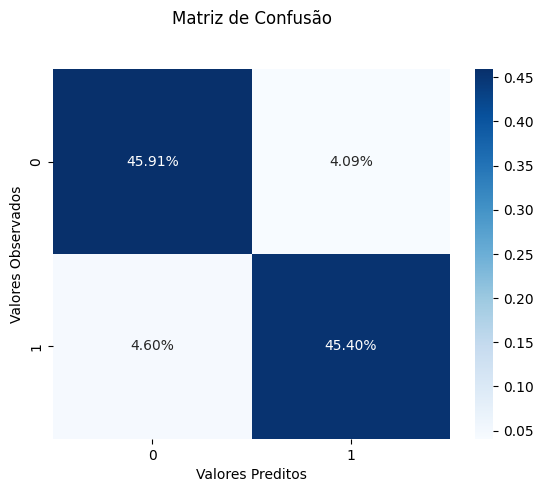

In [98]:
sns.heatmap(matriz_confusao/np.sum(matriz_confusao),
            annot=True, fmt='.2%', cmap='Blues');
          
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Valores Observados')
plt.xlabel('Valores Preditos');

## Atividade 7: Verifique as outras métricas (sensibilidade, especificidade, f1-score).

In [99]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     87403
           1       0.92      0.91      0.91     87403

    accuracy                           0.91    174806
   macro avg       0.91      0.91      0.91    174806
weighted avg       0.91      0.91      0.91    174806



In [100]:
print(modelo.summary())

                           Logit Regression Results                           
Dep. Variable:                 fraude   No. Observations:               174806
Model:                          Logit   Df Residuals:                   174801
Method:                           MLE   Df Model:                            4
Date:                Sun, 06 Aug 2023   Pseudo R-squ.:                  0.6097
Time:                        01:06:57   Log-Likelihood:                -47296.
converged:                       True   LL-Null:                   -1.2117e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.6150      0.040   -166.701      0.000      -6.693      -6.537
dist_casa             0.0220      0.000    129.561      0.000       0.022       0.022
razao_preco_medio     0.

## Atividade 8: Crie a curva ROC para este modelo.

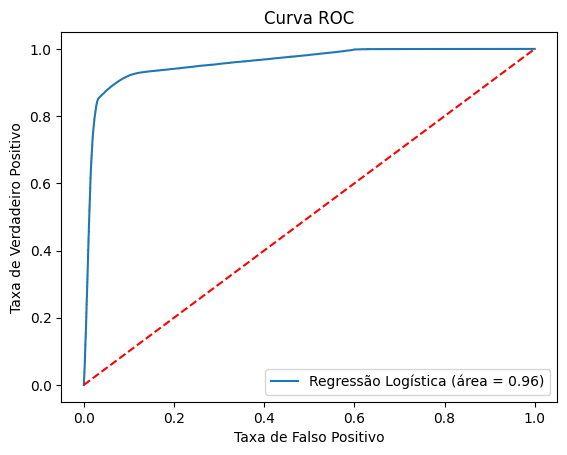

In [101]:

logit_roc_auc = roc_auc_score(y, modelo.predict(X))
fpr, tpr, thresholds = roc_curve(y, modelo.predict(X))
plt.plot(fpr, tpr, label=f'Regressão Logística (área = {round(logit_roc_auc, 2)})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right");

Quanto mais próximo de 1 a área sob a curva ROC estiver, melhor o modelo. No nosso caso a área é de 0.96, indicando que o modelo está bom.

## Atividade 9: Preveja se uma transação com as características abaixo é ou não fraude.

* `dist_casa = 82`
* `dist_ultima_transacao = 13`
* `razao_preco_medio = 14`
* `loja_repetida = 1`
* `usou_chip = 0`
* `usou_pin = 0`
* `online = 1`

In [102]:
# seu código
colunas_new = df.columns[:-1]

In [103]:
valor_new = [82,13,14,1,0,0,1]

In [104]:
data_new =dict(zip(colunas_new,valor_new))

In [105]:
# seu código
df_prev = pd.DataFrame(data = data_new,index=[0])
df_prev2 = df_prev[colunas]


In [106]:
X = sm.add_constant(df_prev2, has_constant='add')

In [107]:
X

,const,dist_casa,razao_preco_medio,usou_pin,online
0,1.0,82,14,0,1


In [108]:
y_pred = (modelo.predict(X) >= 0.5).astype(int)
y_pred

0    1
dtype: int32

<b style='color:red'>O modelo prevê que é uma possível fraude</b>

## Atividade 10: Refaça os exercícios sem realizar o balanceamento de classe e verifique se ocorre algum problema.

In [109]:
# separando as variáveis X e y
X2 = df[colunas]
y2 = df['fraude']

In [110]:
# seu código
X2 = sm.add_constant(X2,has_constant='add')

In [111]:
# criando modelo de regressão logística
modelo2 = sm.Logit(y2, X2).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.147603
         Iterations 12


In [115]:
modelo2.params

const               -10.163361
dist_casa             0.013572
razao_preco_medio     0.795753
usou_pin            -12.392020
online                5.987719
dtype: float64

In [116]:
y_pred2 = (modelo2.predict(X2) >= 0.5).astype(int)

In [117]:
matriz_confusao = confusion_matrix(y2, y_pred2)
matriz_confusao

array([[906420,   6177],
       [ 38577,  48826]], dtype=int64)

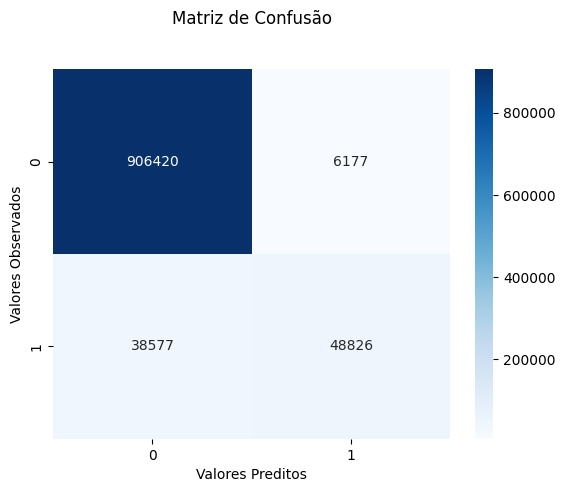

In [118]:
# criando mapa de calor
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Valores Observados')
plt.xlabel('Valores Preditos');

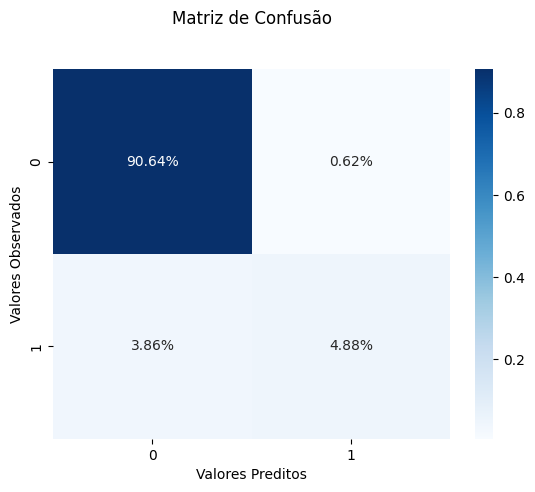

In [119]:
sns.heatmap(matriz_confusao/np.sum(matriz_confusao),
            annot=True, fmt='.2%', cmap='Blues');
          
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Valores Observados')
plt.xlabel('Valores Preditos');

In [121]:
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    912597
           1       0.89      0.56      0.69     87403

    accuracy                           0.96   1000000
   macro avg       0.92      0.78      0.83   1000000
weighted avg       0.95      0.96      0.95   1000000



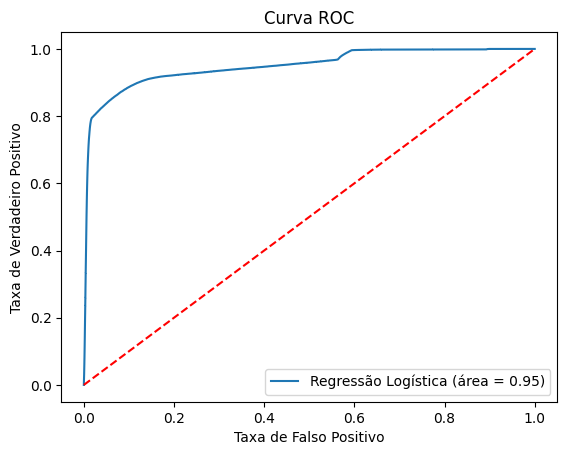

In [122]:
logit_roc_auc = roc_auc_score(y2, modelo2.predict(X2))
fpr, tpr, thresholds = roc_curve(y2, modelo2.predict(X2))
plt.plot(fpr, tpr, label=f'Regressão Logística (área = {round(logit_roc_auc, 2)})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right");

<b style='color:red'> Podemos observar que ambos os modelos tiveram bons resultados, porém o modelo 1 se saiu muito melhor que o 2 para ambas as situações. Acredito que dependa muito da área de negócio, mas eu ainda sim acredito que o modelo 1 é o melhor dado que ele tem melhor previsibilidade de ser ou não ser fraude. </b>